#### Revolut Dividends 2024
This Jupyter notebook is intended to help analyze data from an imported revolut statement in xlsx format regarding dividends collected in 2024.
<br>This is my practice project to learn to work with and analyze data with python and to produce visualizations.

##### What this Jupyter notebook does:
- clean up data from the imported file so it can be analyzed,
- provide info on dividends collected in USD in 2024,
- provide info on dividends collected in EUR in 2024,
- provide a summary for year 2024,
- present visualizations to help showcase the insights obtained.

##### Notes:
- libraries used: pandas, matplotlib.pyplot, matplotlib.cm, matplotlib.dates
- This notebook is designed to process data from your Revolut statement. This statement can be generated from your Revolut Invest section (in app: Invest > More > Documents > Brokerage account > Account statement > select Excel).
- This notebook provides insights for dividends collected in EUR or USD.
- colors for matplotlib https://matplotlib.org/3.3.0/gallery/color/named_colors.html
- colormaps for matplotlib https://matplotlib.org/stable/users/explain/colors/colormaps.html



Importing libraries, importing and cleaning the data

In [ ]:
# Import libraries and load data 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates

dividends = pd.read_excel("randomized_statement.xlsx")

# 1. Remove spaces from column names, set lowercase
dividends.columns = dividends.columns.str.replace(" ", "_").str.lower()

# 2. Update the DF to only contain dividend rows and drop unnecessary columns
dividends = dividends[dividends["type"] == "DIVIDEND"].drop(columns=["quantity", "price_per_share", "fx_rate"])

# 3. Clean total_amount column and convert to float
# Regular expression pattern r"[^\d.]" matches any character that is not a digit (0-9) or a period (.)
# This removes any non-numeric symbols, such as '$' or '€', or thousands separators ','
dividends["total_amount"] = dividends["total_amount"].replace(r"[^\d.]", "", regex=True).astype(float)

# 4. Format the 'date' column to 'YYYY-MM-DD' to exclude the time component when displayed
dividends['date'] = dividends['date'].dt.date # use .dt.date to extract the date only (removes time and timezone info), result becomes a Python `date` object
dividends['date'] = pd.to_datetime(dividends['date']) # convert back to pandas datetime format (needed for plotting later)

# 5. Filter date column for year 2024
dividends = dividends[dividends['date'].dt.year == 2024]

# Have a look at the dataframe we will be working with
dividends.head()

,date,ticker,type,total_amount,currency
90,2024-05-14,AAPL,DIVIDEND,9.72,USD
116,2024-12-10,AAPL,DIVIDEND,14.31,USD
177,2024-05-07,BABA,DIVIDEND,12.89,EUR
192,2024-02-28,BRK.A,DIVIDEND,16.96,EUR
227,2024-08-22,JPM,DIVIDEND,7.08,EUR


Quick overview of the imported statement, list of currencies

In [3]:
# Overview of overall dividends collected per ticker
overview = dividends.groupby(['date', 'ticker', 'currency']).agg(amount=('total_amount', 'sum')).reset_index()
#overview = dividend.groupby('ticker')['total_amount'].sum()
display(overview.head())



,date,ticker,currency,amount
0,2024-01-31,V,EUR,7.32
1,2024-02-28,BRK.A,EUR,16.96
2,2024-03-14,TSLA,EUR,9.38
3,2024-04-21,META,EUR,4.69
4,2024-05-07,BABA,EUR,12.89


Overview

In [4]:
info = pd.DataFrame({
    "Metric": [
        "Currencies present in statement",
        "Total number of payouts", 
        "Number of payouts in USD", 
        "Number of payouts in EUR",
               ],
    "Value": [
        ', '.join(dividends["currency"].unique()),
        overview['amount'].count(),
        dividends[(dividends["currency"] == "USD")].shape[0],
        dividends[(dividends["currency"] == "EUR")].shape[0],
    ]
})

display(info)

,Metric,Value
0,Currencies present in statement,"USD, EUR"
1,Total number of payouts,11
2,Number of payouts in USD,4
3,Number of payouts in EUR,7


Data for year 2024 in USD

,ticker,currency,amount
0,AAPL,USD,24.03
1,NFLX,USD,6.15
2,NVDA,USD,11.03
3,Total,USD,41.21



Visualization 1: USD dividends by ticker


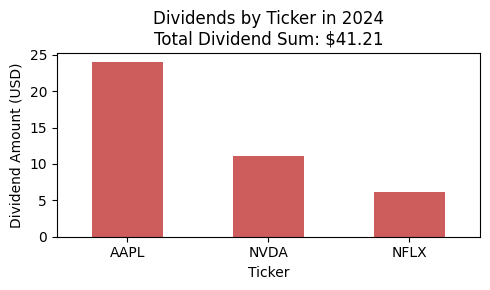

Visualization 2: USD dividends by month


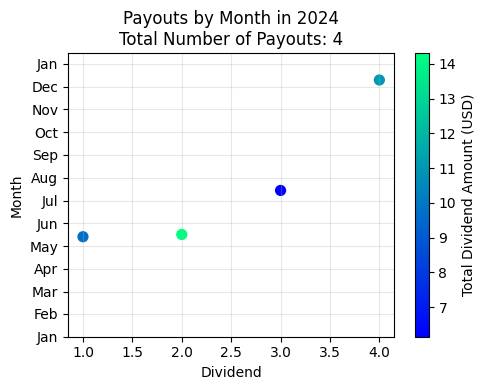

In [5]:
# Filter the 'dividend' DataFrame to include only transactions in USD
dividend_usd = dividends[(dividends["currency"] == "USD")]
# print(dividend_usd)

# Group the data by 'ticker' and 'currency' and calculate the sum of 'total_amount'
dividend_usd_total = dividend_usd.groupby(['ticker', 'currency']).agg(
    amount=('total_amount', 'sum')
    ).reset_index()

# Calculate the total sum of dividends collected in USD for 2024 for the purpose of a total row for the DF
total_sum_usd = dividend_usd_total["amount"].sum()

# Create a DataFrame for the 'Total' row to display the grand total
total_row_usd = pd.DataFrame([{"ticker": "Total", "currency": "USD", "amount": total_sum_usd}])

# Append the 'Total' row to the dividend_usd_total DF
dividend2024_usd = pd.concat([dividend_usd_total, total_row_usd], ignore_index=True)  # ignore_index=True to have a clean, new index

display(dividend2024_usd)

# Add a visualization showcasing dividends collected per ticker in USD in 2024
print(f'\nVisualization 1: USD dividends by ticker')
USD_dividends_by_ticker = dividend_usd.groupby('ticker')['total_amount'].sum()

plt.figure(figsize=(5,3))
USD_dividends_by_ticker.sort_values(ascending=False).plot(
    kind='bar', color='indianred'
    )
plt.title(f"Dividends by Ticker in 2024\nTotal Dividend Sum: ${total_sum_usd:.2f}")
plt.xlabel("Ticker")
plt.ylabel("Dividend Amount (USD)")
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('Dividends_by_Ticker_USD_2024.png')
plt.show()

# Add a visualization showcasing months of payout in USD in 2024
print(f'Visualization 2: USD dividends by month')

ypoints = dividend_usd.sort_values('date')['date']
xpoints = range(1, len(ypoints) + 1) # start at 1, not 0
# Plot
plt.figure(figsize=(5, 4))
sc = plt.scatter(xpoints, ypoints, c=dividend_usd['total_amount'], cmap='winter', s=50)

# Add colorbar
plt.colorbar(sc, label='Total Dividend Amount (USD)')

# # Format y-axis to show abbreviated month names
# plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b'))
# plt.gca().yaxis.set_major_locator(mdates.MonthLocator())

ax = plt.gca()
ax.set_ylim(pd.to_datetime('2024-01-01'), pd.to_datetime('2025-01-15'))  # Set the y-axis limits explicitly to cover the full year of 2024
ax.yaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks on the y-axis to appear at the start of each month
ax.yaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Show abbreviated month names

plt.title(f'Payouts by Month in 2024\nTotal Number of Payouts: {dividend_usd['date'].count()}')
plt.xlabel('Dividend')
plt.ylabel('Month')

plt.grid(True, linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig('Dividends_by_Month_USD_2024.png')
plt.show()

Data for year 2024 in EUR

,ticker,currency,amount
0,BABA,EUR,12.89
1,BRK.A,EUR,16.96
2,JPM,EUR,7.08
3,META,EUR,4.69
4,TSLA,EUR,14.90
5,V,EUR,7.32
6,Total,EUR,63.84


Visualization 1: EUR dividends by ticker


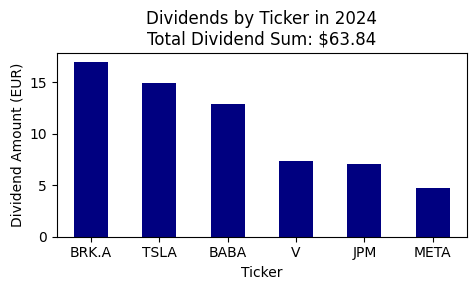

Visualization 2: EUR dividends by month


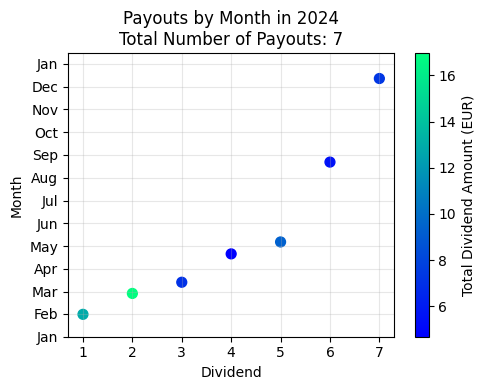

In [6]:
# Filter the 'dividend' DataFrame to include only transactions in EUR
dividend_eur = dividends[(dividends["currency"] == "EUR")]
# print(dividend_eur)

# Group the data by 'ticker' and 'currency' and calculate the sum of 'total_amount'
dividend_eur_total = dividend_eur.groupby(['ticker', 'currency']).agg(
    amount=('total_amount', 'sum')
    ).reset_index()

# Calculate the total sum of dividends collected in USD for 2024 for the purpose of a total row for the DF
total_sum_eur = dividend_eur_total["amount"].sum()

# Create a DataFrame for the 'Total' row to display the grand total
total_row_eur = pd.DataFrame([{"ticker": "Total", "currency": "EUR", "amount": total_sum_eur}])

# Append the 'Total' row to the dividend_usd_total DF
dividend2024_eur = pd.concat([dividend_eur_total, total_row_eur], ignore_index=True)  # ignore_index=True to have a clean, new index

display(dividend2024_eur)

# Add a visualization showcasing dividends collected per ticker in USD in 2024
print(f'Visualization 1: EUR dividends by ticker')
eur_dividends_by_ticker = dividend_eur.groupby('ticker')['total_amount'].sum()

plt.figure(figsize=(5,3))
eur_dividends_by_ticker.sort_values(ascending=False).plot(
    kind='bar', color='navy'
    )
plt.title(f"Dividends by Ticker in 2024\nTotal Dividend Sum: ${total_sum_eur:.2f}")
plt.xlabel("Ticker")
plt.ylabel("Dividend Amount (EUR)")
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig('Dividends_by_Ticker_EUR_2024.png')
plt.show()

# Add a visualization showcasing months of payout in USD in 2024
print(f'Visualization 2: EUR dividends by month')

ypoints = dividend_eur.sort_values('date')['date']
xpoints = range(1, len(ypoints) + 1) # start at 1, not 0
# Plot
plt.figure(figsize=(5, 4))
sc = plt.scatter(xpoints, ypoints, c=dividend_eur['total_amount'], cmap='winter', s=50)

# Add colorbar
plt.colorbar(sc, label='Total Dividend Amount (EUR)')

ax = plt.gca()
ax.set_ylim(pd.to_datetime('2024-01-01'), pd.to_datetime('2025-01-15'))  # Set the y-axis limits explicitly to cover the full year of 2024
ax.yaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks on the y-axis to appear at the start of each month
ax.yaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Show abbreviated month names

plt.title(f'Payouts by Month in 2024\nTotal Number of Payouts: {dividend_eur['date'].count()}')
plt.xlabel('Dividend')
plt.ylabel('Month')

plt.grid(True, linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig('Dividends_by_Moth_EUR_2024.png')
plt.show()

#### Summary and key insights for year 2024

In [7]:
# A list of unique tickers which are present in the statement
unique_tickers = dividends['ticker'].unique()
# The ticker which had the highest sum paid out in 2024
top_ticker = dividends.groupby('ticker')['total_amount'].sum().idxmax()

# top_ticker_2024 = dividends[dividends['date'].dt.year == 2024].groupby('ticker')['total_amount'].sum().idxmax()
print(f'Here are the key insights:')

pd.set_option('display.max_colwidth', None) # wrap text in df

summary = pd.DataFrame({
    "Metric": [
        "Number of dividend-paying tickers",
        "List of tickers",
        "Highest paying ticker", 
        "Total number of payouts", 
        "Number of payouts in USD", 
        "Number of payouts in EUR",
        "Total amount in USD", 
        "Total amount in EUR",
        "Grand total converted to EUR",
        "Grand total converted to USD",
        "FX rate (Updated on 2025/03/26)"
               ],
    "Value": [
        len(unique_tickers),
        ", ".join(unique_tickers),
        top_ticker,
        overview['amount'].count(),
        dividends[(dividends["currency"] == "USD")].shape[0],
        dividends[(dividends["currency"] == "EUR")].shape[0],
        f"€{total_sum_eur:.2f}",
        f"${total_sum_usd:.2f}",
        f"€{total_sum_eur + (total_sum_usd * 0.93):.2f}",
        f"${total_sum_usd + (total_sum_eur * 1.08):.2f}",
        "1 EUR = 1.08 USD, 1 USD = 0.93 EUR"
    ]
})

display(summary)

summary.to_excel('summary.xlsx', index=False) # export the summary df as an xlsx file

Here are the key insights:


,Metric,Value
0,Number of dividend-paying tickers,9
1,List of tickers,"AAPL, BABA, BRK.A, JPM, META, NFLX, NVDA, TSLA, V"
2,Highest paying ticker,AAPL
3,Total number of payouts,11
4,Number of payouts in USD,4
5,Number of payouts in EUR,7
6,Total amount in USD,€63.84
7,Total amount in EUR,$41.21
8,Grand total converted to EUR,€102.17
9,Grand total converted to USD,$110.16


Visualization: A bar chart showing all dividends collected by ticker in 2024 in both EUR and USD


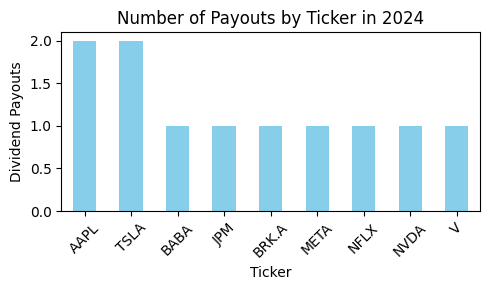

In [8]:
print('Visualization: A bar chart showing all dividends collected by ticker in 2024 in both EUR and USD')
dividends_by_ticker = dividends.groupby('ticker')['total_amount'].count()

plt.figure(figsize=(5,3))
dividends_by_ticker.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Number of Payouts by Ticker in 2024")
plt.xlabel("Ticker")
plt.ylabel("Dividend Payouts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('Dividend_Payouts_2024.png')
plt.show()
